# Overview

# Imports

In [1]:
from pathlib import Path
import sys
import os
from typing import Dict, List, Tuple

import pyfaidx

import importlib

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import rbpnet.utils
import rbpnet.models
import rbpnet.bin.explain

2024-11-11 20:47:04.871243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 20:47:04.871277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 20:47:04.872174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 20:47:06.296104: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)>

# Load

In [3]:
filepath_model = Path("../data/rbpnet_models/QKI.model.h5")
model = rbpnet.models.load_model(filepath_model)
model.summary()

Model: "RBPNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, None, 4)]            0         []                            
                                                                                                  
 first_layer_conv (FirstLay  (None, None, 128)            6272      ['sequence[0][0]']            
 erConv)                                                                                          
                                                                                                  
 body_conv_1 (BodyConv)      (None, None, 128)            98944     ['first_layer_conv[0][0]']    
                                                                                                  
 body_conv_2 (BodyConv)      (None, None, 128)            98944     ['body_conv_1[0][0]']    

In [4]:
main_human_chroms = [f"chr{i}" for i in range(1,23)] + ["chrX", "chrY"]

path = "../example_data/hg38.chrom.sizes"
hg38_chromsizes = pd.read_csv(path, header=None, index_col=None, sep="\t", names=["chr", "size"]).set_index('chr')['size'].to_dict()

fasta_path = "../example_data/hg38.chr21.fa.gz"
fa = pyfaidx.Faidx(str(fasta_path))

# Note: this can be used as a context-manager too.
with pyfaidx.Faidx(str(fasta_path)) as cm_fa:
    # NOTE: specific to this library : the coordinates should be 1-based, close-ended, i.e. [1, 1] returns the "first" base.
    seq_fetched = str(cm_fa.fetch("chr21", 33_031_601, 33_032_000))
    assert (len(seq_fetched) == 400)

In [29]:
encore_peaks_columns = [
    "chrom",
    "start",
    "end",
    "name",
    "score",
    "strand",
    "signal_value",
    "p_value",
    "q_value",
    "peak",
]

# From https://www.encodeproject.org/files/ENCFF815XNW/@@download/ENCFF815XNW.bed.gz
peaks = pd.read_csv(
    "../data/encore_peaks/ENCFF815XNW.bed.gz",
    header=None,
    index_col=None,
    sep="\t",
    names=encore_peaks_columns,
)

# Filter on : 1) main chromosomes ; 2) score at maximum value ; 3) signal value above threshold.
peaks = (
    peaks.loc[
        lambda df: (
            (peaks["chrom"].isin(main_human_chroms))
            & (df["chrom"] == "chr21")
            & (df["strand"] == "+")
        ),
        :,
    ]
    .sort_values(by="signal_value", ascending=True)
    .reset_index(drop=True)
    .copy()
)
# .sort_values(by=["chrom","start"], ascending=[True,True])

In [26]:
import tensorflow as tf

import igrads

def explain_step(sequence, model):
    """Returns the 1D attribution for a single input sequence.

    The 2D (input_length, 4) attribution tensor is flattened to a 1D array, as at
rojects/hzm/rbpnet/rbpnet/bin/explain.py:0'>0</a>;32m   (...)
        np.ndarray: 1D numpy array with attribution values.
    """
    def attribution(inputs, model):
        pred = model.predict(tf.expand_dims(inputs, axis=0))
        return igrads.integrated_gradients(inputs=inputs, model=model, baseline=0, target_mask=pred, steps=50)

    return {key: tf.reduce_sum(value, axis=1).numpy() for key, value in attribution(rbpnet.utils.sequence2onehot(sequence), model).items()}

In [30]:
intervals = []
sequences = []
predictions = []
igs = []

for i, row in peaks.head(100).iterrows():
    # Note: eCLIP peaks' 5prime end is a better location of the RBP binding site than the peak center.
    # We extract here intervals of 400bp centered around the 5' end of the peak.
    # Note: this is to be adapted for minus strand sequences (along with taking the reverse complement).
    start = row['start'] - 200 +1
    end = row['start'] + 200 # do not forget : 1-based interval query ; while the BED is 0-based by convention.
    if start < 0 or end >= hg38_chromsizes[row['chrom']]:
        continue

    interval = f"{row['chrom']}:{start}-{end}:+"
    seq = str(fa.fetch(row['chrom'], start, end)).upper()

    preds = model.predict_from_sequence(seq)

    #TODO: bugged
    #ig_model = explain_step(sequence=seq, model=model)

    intervals.append(interval)
    sequences.append(seq)
    predictions.append(preds)
    #igs.append(ig_model)

for i, row in peaks.tail(100).iterrows():
    # Note: eCLIP peaks' 5prime end is a better location of the RBP binding site than the peak center.
    # We extract here intervals of 400bp centered around the 5' end of the peak.
    # Note: this is to be adapted for minus strand sequences (along with taking the reverse complement).
    start = row['start'] - 200 +1
    end = row['start'] + 200 # do not forget : 1-based interval query ; while the BED is 0-based by convention.
    if start < 0 or end >= hg38_chromsizes[row['chrom']]:
        continue

    interval = f"{row['chrom']}:{start}-{end}:+"
    seq = str(fa.fetch(row['chrom'], start, end)).upper()

    preds = model.predict_from_sequence(seq)

    #TODO: bugged
    #ig_model = explain_step(sequence=seq, model=model)

    intervals.append(interval)
    sequences.append(seq)
    predictions.append(preds)
    #igs.append(ig_model)



In [36]:
df_mixcoef = pd.Series([p['QKI_HepG2_mixing_coefficient'].numpy()[0] for p in predictions], name='QKI_HepG2_mixing_coefficient').to_frame()
df_mixcoef['seq_group'] = ['top100']*100 + ['bottom100']*100

<Axes: xlabel='seq_group', ylabel='QKI_HepG2_mixing_coefficient'>

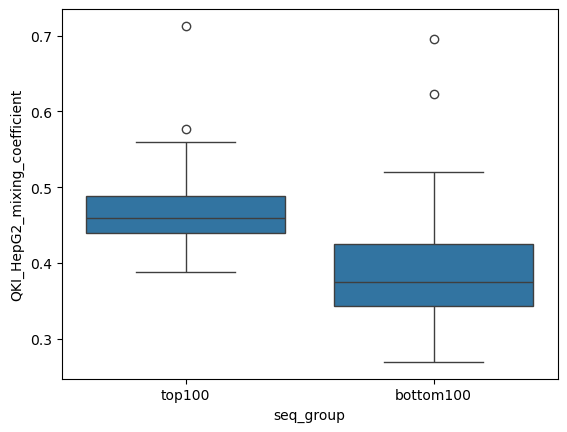

In [37]:
sns.boxplot(
    x='seq_group',
    y='QKI_HepG2_mixing_coefficient',
    data=df_mixcoef,
)